_Lambda School Data Science, Classification 1_

This sprint, your project is about water pumps in Tanzania. Can you predict which water pumps are faulty?

# Decision Trees, Data Cleaning

#### Objectives
- clean data with outliers
- impute missing values
- use scikit-learn for decision trees
- understand why decision trees are useful to model non-linear, non-monotonic relationships and feature interactions
- get and interpret feature importances of a tree-based model

#### Links

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)

### OPTIONAL SETUP

#### 1. Downgrade pandas to fix pivot table bug

For this lesson, I'll downgrade pandas from 0.24 to 0.23.4, because of a known issue: https://github.com/pandas-dev/pandas/issues/25087

I'm making a pivot table just for demonstration during this lesson, but it's not required for your assignment. So, you don't need to downgrade pandas if you don't want to.

#### 2. Install graphviz to visualize trees

This is also not required for your assignment.

Anaconda:  
```
conda install python-graphviz
```

Google Colab:  
```
!pip install graphviz
!apt-get install graphviz
```


In [1]:
!pip install pandas==0.23.4
!pip install graphviz
!apt-get install graphviz

  Using cached https://files.pythonhosted.org/packages/6b/dc/3a88b7bf8437f3f052fc90de72f28c06248142821a7f108e10ff3be5eb59/pandas-0.23.4-cp37-cp37m-macosx_10_6_intel.macosx_10_9_intel.macosx_10_9_x86_64.macosx_10_10_intel.macosx_10_10_x86_64.whl
Error checking for conflicts.
Traceback (most recent call last):
  File "/Users/dwightchurchill/anaconda3/lib/python3.7/site-packages/pip/_vendor/pkg_resources/__init__.py", line 2897, in _dep_map
    return self.__dep_map
  File "/Users/dwightchurchill/anaconda3/lib/python3.7/site-packages/pip/_vendor/pkg_resources/__init__.py", line 2691, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/dwightchurchill/anaconda3/lib/python3.7/site-packages/pip/_vendor/pkg_resources/__init__.py", line 2888, in _parsed_pkg_info
    return self._pkg_info
  File "/Users/dwightchurchill/anaconda3/lib/pyt

## Clean data with outliers, impute missing values (example solutions)

In [2]:
# !pip install category_encoders

In [18]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

In [17]:
pd.set_option('display.float_format', '{:.2f}'.format)

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv('https://drive.google.com/uc?export=download&id=14ULvX0uOgftTB2s97uS8lIx1nHGQIB0P'), 
                 pd.read_csv('https://drive.google.com/uc?export=download&id=1r441wLr7gKGHGLyPpKauvCuUOU556S2f'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv('https://drive.google.com/uc?export=download&id=1wvsYl9hbRbZuIuoaLWCsW_kbcxCdocHz')
sample_submission = pd.read_csv('https://drive.google.com/uc?export=download&id=1kfJewnmhowpUo381oSn3XqsQ6Eto23XV')

# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)

# Print dataframe shapes
print('train', train.shape)
print('val', val.shape)
print('test', test.shape)

train (47520, 41)
val (11880, 41)
test (14358, 40)


Some of the locations are at ["Null Island"](https://en.wikipedia.org/wiki/Null_Island) instead of Tanzania.

In [5]:
train.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,47520.00,47520.00,47520.00,47520.00,47520.00,47520.00,47520.00,47520.00,47520.00,47520.00
mean,37037.92,321.93,669.57,34.08,-5.71,0.48,15.26,5.62,179.81,1302.77
std,21412.10,3197.24,693.01,6.55,2.94,13.31,17.53,9.62,463.08,950.96
min,0.00,0.00,-63.00,0.00,-11.65,0.00,1.00,0.00,0.00,0.00
25%,18482.75,0.00,0.00,33.09,-8.53,0.00,5.00,2.00,0.00,0.00
50%,36986.50,0.00,372.50,34.91,-5.02,0.00,12.00,3.00,25.00,1986.00
75%,55450.25,25.00,1320.00,37.17,-3.33,0.00,17.00,5.00,215.00,2004.00
max,74247.00,350000.00,2770.00,40.34,-0.00,1776.00,99.00,80.00,15300.00,2013.00


In [6]:
train['latitude'].max()

-2e-08

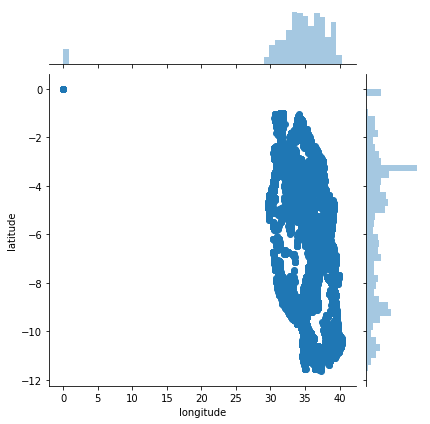

In [4]:
sns.jointplot(x='longitude', y='latitude', data=train);

#### Define a function to wrangle train, validate, and test sets in the same way.

Fix the location, and do more data cleaning and feature engineering.

In [21]:
def wrangle(X):
    """Wrangles train, validate, and test sets in the same way"""
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace them with the column mean.
    cols_with_zeros = ['construction_year', 'longitude', 'latitude']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col] = X[col].fillna(X[col].mean())
        
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract year from date_recorded
    X['year_recorded'] = X['date_recorded'].dt.year
    
    # quantity & quantity_group are duplicates, so drop one
    X = X.drop(columns='quantity_group')
    
    # for categoricals with missing values, fill with the category 'MISSING'
    categoricals = X.select_dtypes(exclude='number').columns
    for col in categoricals:
        X[col] = X[col].fillna('MISSING')
    
    return X


train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

Now the locations look better.

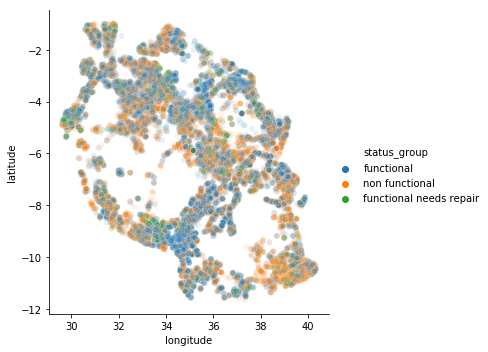

In [8]:
sns.relplot(x='longitude', y='latitude', hue='status_group', 
            data=train, alpha=0.1);

#### Select features

In [22]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target & id
train_features = train.drop(columns=[target, 'id'])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

#### Encode categoricals, scale features, fit and score Logistic Regression model, make predictions

In [23]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

# Encoder: fit_transform on train, transform on val & test
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

# Scaler: fit_transform on train, transform on val & test
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# Model: Fit on train, score on val, predict on test
model = LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=-1)
model.fit(X_train_scaled, y_train)
print('Validation Accuracy', model.score(X_val_scaled, y_val))
y_pred = model.predict(X_test_scaled)

# Write submission csv file
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission-02.csv', index=False)

Validation Accuracy 0.7296296296296296


#### Get and plot coefficients

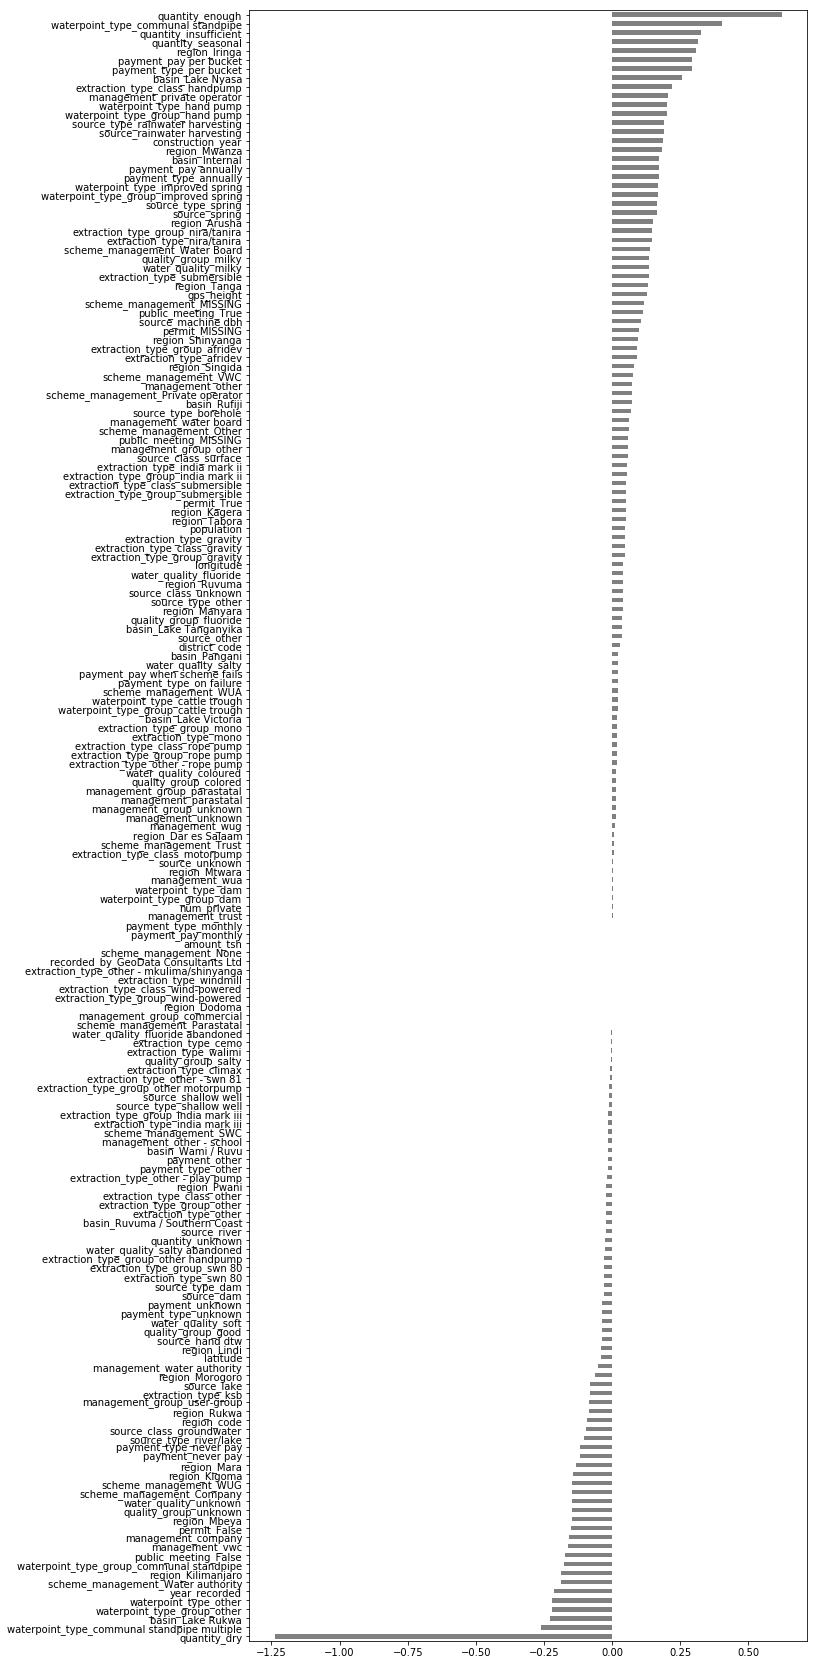

In [24]:
coefficients = pd.Series(model.coef_[0], X_train_encoded.columns)
plt.figure(figsize=(10,30))
coefficients.sort_values().plot.barh(color='grey');

## Use scikit-learn for decision trees

### Compare a Logistic Regression with 2 features, longitude & latitude ...

In [25]:
train_location = X_train[['longitude', 'latitude']].copy()
val_location = X_val[['longitude', 'latitude']].copy()

In [26]:
lr = LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=-1)
lr.fit(train_location, y_train)
print('Logistic Regression')
print('Train Accuracy', lr.score(train_location, y_train))
print('Validation Accuracy', lr.score(val_location, y_val))

Logistic Regression
Train Accuracy 0.5430765993265994
Validation Accuracy 0.5430976430976431


### ... versus a Decision Tree Classifier with 2 features, longitude & latitude

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [29]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(train_location, y_train)
print('Decision Tree')
print('Train Accuracy', dt.score(train_location, y_train))
print('Validation Accuracy', dt.score(val_location, y_val))

Decision Tree
Train Accuracy 0.984196127946128
Validation Accuracy 0.6301346801346801


In [30]:
dt = DecisionTreeClassifier(random_state=42,max_depth=15)
dt.fit(train_location, y_train)
print('Decision Tree')
print('Train Accuracy', dt.score(train_location, y_train))
print('Validation Accuracy', dt.score(val_location, y_val))

Decision Tree
Train Accuracy 0.7712962962962963
Validation Accuracy 0.6482323232323233


## Understand why decision trees are useful to model non-linear, non-monotonic relationships and feature interactions

### Visualize decision tree

https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html

In [50]:
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(dt,
                          out_file=None,
                          max_depth=3,
                          feature_names=train_location.columns,
                          class_names=dt.classes_,
                          impurity=False,
                          filled=True,
                          proportion=True,
                          rotate=True,
                          rounded=True)
graphviz.Source(dot_data)

ValueError: Length of feature_names, 7 does not match number of features, 2

### Make 3 heatmaps, with longitude & latitude
- Actual % of functional waterpumps
- Decision Tree predicted probability of functional waterpumps
- Logistic Regression predicted probability of functional waterpumps

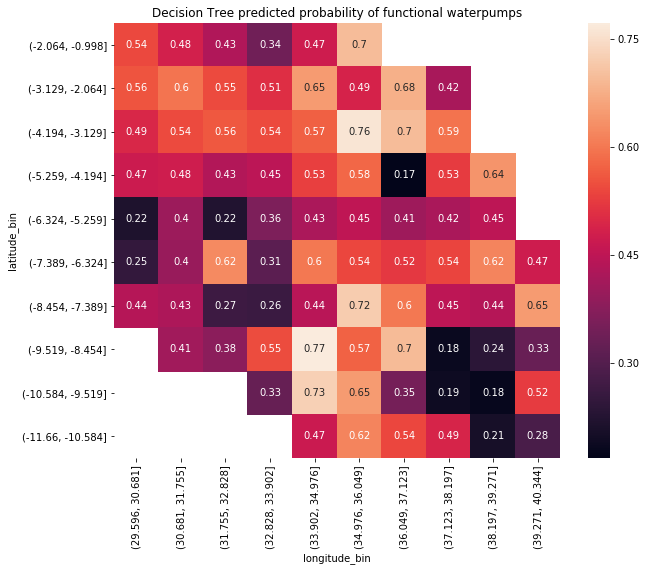

In [44]:
train_location['latitude_bin'] = pd.cut(train_location['latitude'], bins=10)
train_location['longitude_bin'] = pd.cut(train_location['longitude'], bins=10)
train_location['functional'] = train['status_group'] == 'functional'

table = train_location.pivot_table(values='dt_pred_proba_functional', 
                                   index='latitude_bin', 
                                   columns='longitude_bin',
                                   aggfunc='mean')

plt.figure(figsize=(10,8))
plt.title('Decision Tree predicted probability of functional waterpumps')
sns.heatmap(table[::-1], annot=True);

In [42]:
dt_pred_proba = dt.predict_proba(train_location[['longitude', 'latitude']])
train_location['dt_pred_proba_functional'] = dt_pred_proba[:,0]

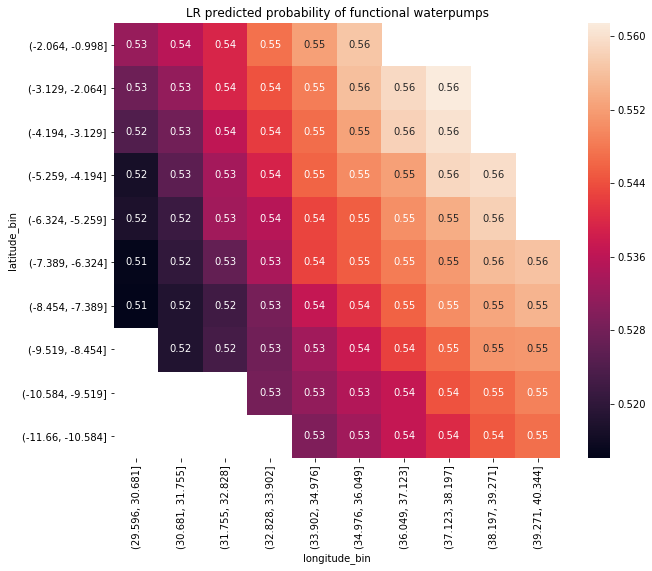

In [46]:
lr_pred_proba = lr.predict_proba(train_location[['longitude', 'latitude']])
train_location['lr_pred_proba_functional'] = lr_pred_proba[:,0]

table = train_location.pivot_table(values='lr_pred_proba_functional', 
                                   index='latitude_bin', 
                                   columns='longitude_bin',
                                   aggfunc='mean')

plt.figure(figsize=(10,8))
plt.title('LR predicted probability of functional waterpumps')
sns.heatmap(table[::-1], annot=True);

### Interlude #1: predicting golf putts
(1 feature, non-linear, regression)

https://statmodeling.stat.columbia.edu/2008/12/04/the_golf_puttin/

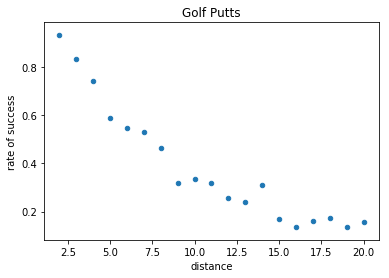

In [47]:
columns = ['distance', 'tries', 'successes']
data = [[2, 1443, 1346],
        [3, 694, 577],
        [4, 455, 337],
        [5, 353, 208],
        [6, 272, 149],
        [7, 256, 136],
        [8, 240, 111],
        [9, 217, 69],
        [10, 200, 67],
        [11, 237, 75],
        [12, 202, 52],
        [13, 192, 46],
        [14, 174, 54],
        [15, 167, 28],
        [16, 201, 27],
        [17, 195, 31],
        [18, 191, 33],
        [19, 147, 20],
        [20, 152, 24]]

putts = pd.DataFrame(columns=columns, data=data)
putts['rate of success'] = putts['successes'] / putts['tries']
putts.plot('distance', 'rate of success', kind='scatter', title='Golf Putts');

#### Compare Linear Regression ... 

R^2 Score 0.8695850610243295


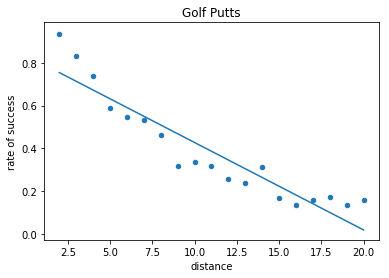

In [48]:
from sklearn.linear_model import LinearRegression

putts_X = putts[['distance']]
putts_y = putts['rate of success']
lr = LinearRegression()
lr.fit(putts_X, putts_y)
print('R^2 Score', lr.score(putts_X, putts_y))
ax = putts.plot('distance', 'rate of success', kind='scatter', title='Golf Putts')
ax.plot(putts_X, lr.predict(putts_X));

#### ... versus a Decision Tree Regressor
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

In [49]:
import graphviz
from ipywidgets import interact
from sklearn.tree import DecisionTreeRegressor, export_graphviz

def viztree(decision_tree, feature_names):
    dot_data = export_graphviz(decision_tree, out_file=None, feature_names=feature_names, 
                               filled=True, rounded=True)   
    return graphviz.Source(dot_data)

def putts_tree(max_depth=1):
    tree = DecisionTreeRegressor(max_depth=max_depth)
    tree.fit(putts_X, putts_y)
    print('R^2 Score', tree.score(putts_X, putts_y))
    ax = putts.plot('distance', 'rate of success', kind='scatter', title='Golf Putts')
    ax.step(putts_X, tree.predict(putts_X), where='mid')
    plt.show()
    display(viztree(tree, feature_names=['distance']))

interact(putts_tree, max_depth=(1,6,1));

interactive(children=(IntSlider(value=1, description='max_depth', max=6, min=1), Output()), _dom_classes=('wid…

### Interlude #2: Simple housing 
(2 features, regression)

https://christophm.github.io/interpretable-ml-book/interaction.html#feature-interaction

In [51]:
columns = ['Price', 'Good Location', 'Big Size']

data = [[300000, 1, 1], 
        [200000, 1, 0], 
        [250000, 0, 1], 
        [150000, 0, 0]]

house = pd.DataFrame(columns=columns, data=data)
house

,Price,Good Location,Big Size
0,300000,1,1
1,200000,1,0
2,250000,0,1
3,150000,0,0


#### Compare Linear Regression ... 

In [52]:
house_X = house.drop(columns='Price')
house_y = house['Price']
lr = LinearRegression()
lr.fit(house_X, house_y)
print('R^2', lr.score(house_X, house_y))
print('Intercept \t', lr.intercept_)
coefficients = pd.Series(lr.coef_, house_X.columns)
print(coefficients.to_string())

R^2 1.0
Intercept 	 150000.0
Good Location    50000.00
Big Size        100000.00


#### ... versus a Decision Tree Regressor

R^2 1.0


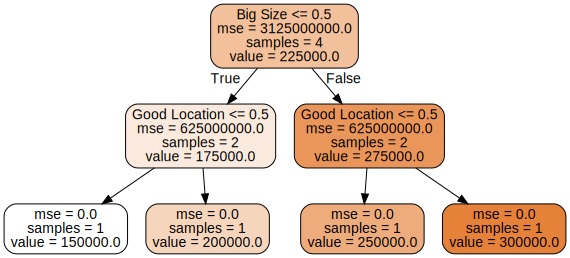

In [53]:
tree = DecisionTreeRegressor()
tree.fit(house_X, house_y)
print('R^2', tree.score(house_X, house_y))
viztree(tree, feature_names=house_X.columns)

### Simple housing, with a twist: _Feature Interaction_

In [54]:
house.loc[0, 'Price'] = 400000
house_X = house.drop(columns='Price')
house_y = house['Price']
house

,Price,Good Location,Big Size
0,400000,1,1
1,200000,1,0
2,250000,0,1
3,150000,0,0


#### Compare Linear Regression ... 

In [0]:
lr = LinearRegression()
lr.fit(house_X, house_y)
print('R^2', lr.score(house_X, house_y))
print('Intercept \t', lr.intercept_)
coefficients = pd.Series(lr.coef_, house_X.columns)
print(coefficients.to_string())

#### ... versus a Decision Tree Regressor

In [0]:
tree = DecisionTreeRegressor()
tree.fit(house_X, house_y)
print('R^2', tree.score(house_X, house_y))
viztree(tree, feature_names=house_X.columns)

## Get and interpret feature importances of a tree-based model

# Assignment
- Start a clean notebook, or continue with yesterday's assignment notebook.
- Continue to participate in our Kaggle competition with the Tanzania Waterpumps data. 
- Do more exploratory data analysis, data cleaning, feature engineering, and feature selection.
- Try a Decision Tree Classifier. 
- Submit new predictions.
- Commit your notebook to your fork of the GitHub repo.

## Stretch Goals
- Create visualizations and share on Slack.
- Read more about decision trees and tree ensembles. You can start with the links at the top of this notebook.
- Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.
